In [1]:
%matplotlib inline
import pykoopman as pk
from pykoopman.common.examples import rk4,square_wave  # required for example system
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility

import warnings
warnings.filterwarnings('ignore')

In [2]:
def runge_kutta_FHN_network(ini, control, tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A): 

    x=np.zeros((tsteps,d,N))
    x[0]=ini    
    for ts in np.arange(0,tsteps-1):
        k1 = dt* ODE_FHN_network(x[ts],ts,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k2 = dt* ODE_FHN_network(x[ts] + k1/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k3 = dt* ODE_FHN_network(x[ts] + k2/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k4 = dt* ODE_FHN_network(x[ts] + k3 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu, sigma, A)
        x[ts+1]= x[ts] + (1/6)* (k1 + 2*k2 + 2*k3 + k4)
    return x

def ODE_FHN_network(t,x,control, alpha=3 , beta=4, gamma=3/2, delta=0, epsilon=0.5, tau=20, mu=1.3 ,sigma=0.21, A=np.zeros((2,))):

    out=np.zeros(x.shape)
    #control=control.reshape(tsteps,N)
    Coupling = 0
    out[0]= R(x[0], alpha , beta, gamma) - x[1] + mu + control + sigma * Coupling
    out[1]= (1/tau)* (x[0] + delta  - epsilon* x[1])
    return out  

def R(x, alpha , beta, gamma):

    return -alpha* x**3 + beta *x**2 - gamma* x 

def rk4(t, x, u, _dt=0.01, func=ODE_FHN_network):
    # 4th order Runge-Kutta
    k1 = func(t, x, u)
    k2 = func(t, x + k1 * _dt / 2, u)
    k3 = func(t, x + k2 * _dt / 2, u)
    k4 = func(t, x + k1 * _dt, u)
    return x + (_dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [3]:
parameters={
        'alpha':3.0,
        'beta':4.0,
        'gamma':3./2,
        'delta':0,
        'epsilon':0.5,
        'tau':20.0,
    'mu': 0.378,
    'sigma': 0.21,
    'A': np.zeros((2,))
    
}

In [4]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length

In [5]:
# Time vector
t = np.arange(0, n_int*dT, dT)

# Uniform random distributed forcing in [-1, 1]
u = 2*rnd.random([n_int, n_traj])-1 #2*np.zeros([n_int, n_traj])

# Uniform distribution of initial conditions
x = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, ODE_FHN_network)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

In [6]:
X.shape

(2, 200000)

In [7]:
np.savetxt("DiscreteSpectrumExample_train3_x.csv", X.T, delimiter=",")

In [22]:
import pandas as pd
df = pd.read_csv('/Users/shi/Downloads/DiscreteSpectrumExample_val_x.csv', sep=',', header=None)

In [53]:
df.values.T.shape

(2, 51000)

In [52]:
X.shape

(2, 255000)

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

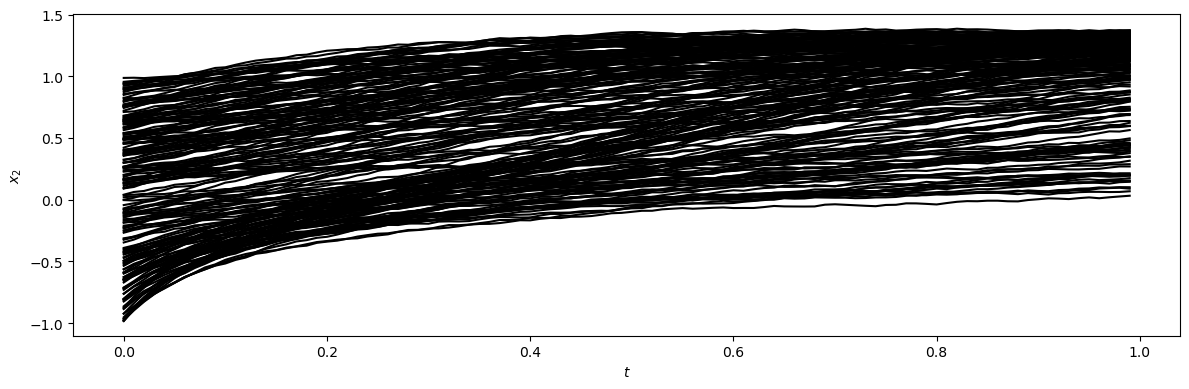

In [8]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[0, 0:100], 'k')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

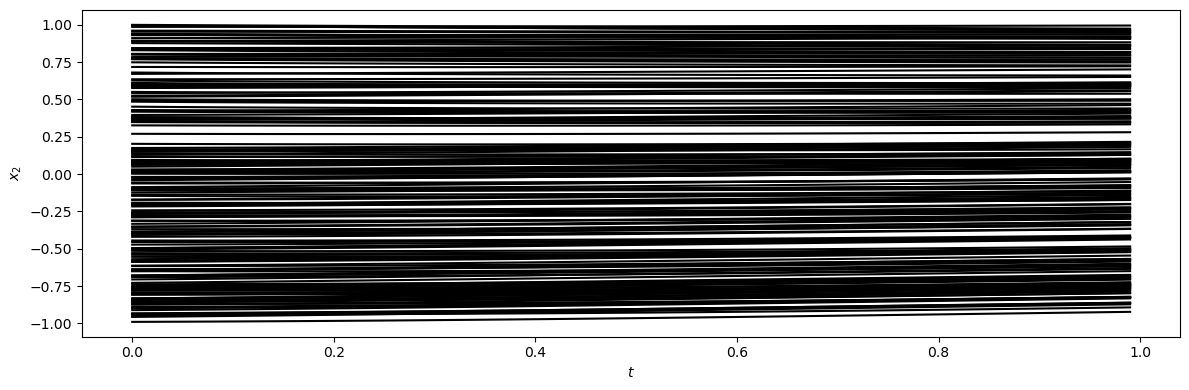

In [9]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

In [10]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_state=True)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.62038938,  0.31967068, -0.98213415, -0.31446064, -0.81375325,
         0.53971317,  1.40058524, -0.98357651,  1.26261282,  0.91812187],
       [ 0.18472283,  1.13509468, -0.57561522, -0.99014132,  0.74634023,
        -0.80474788,  0.86158657,  1.06136096, -0.5101437 ,  0.93292241]]),
                                        rbf_type='thinplate'),
        regressor=EDMDc())

In [11]:
n_int = 600  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step+1) for step in range(n_int)])
x = np.array([0.5, 0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, ODE_FHN_network)
    Xtrue[:, step] = y.reshape(n_states,)

In [12]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

Text(0.5, 1.0, 'L2 norm error = 0.36532160746079684')

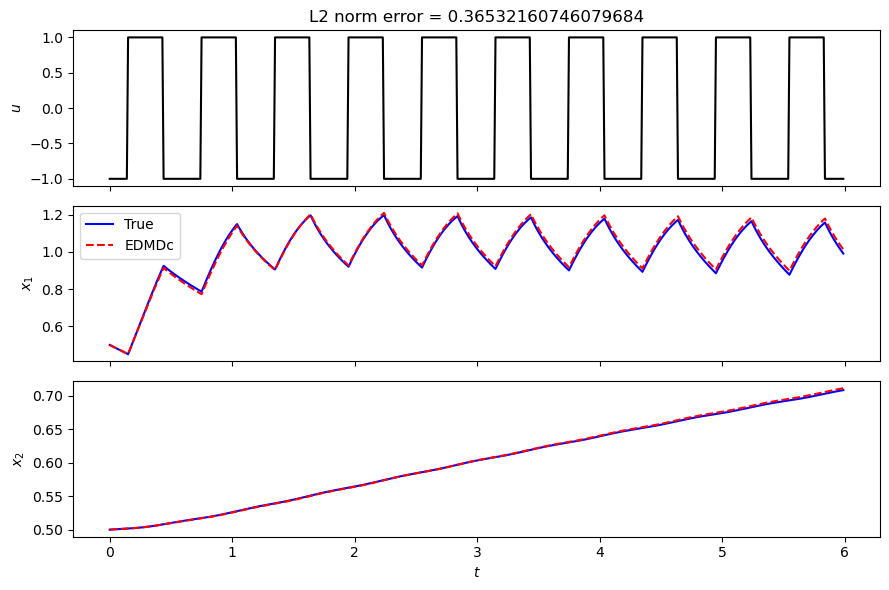

In [13]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop.T)
axs[0].set_title(f"L2 norm error = {err}")

In [14]:
obsv_poly = pk.observables.Polynomial(degree=2)
model_poly = pk.Koopman(observables=obsv_poly, regressor=EDMDc)
model_poly.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=Polynomial(), regressor=EDMDc())

In [15]:
obsv_poly.get_feature_names(["x1", "x2"])

['1', 'x1', 'x2', 'x1^2', 'x1 x2', 'x2^2']

In [16]:
model_poly.C.shape

(2, 6)

In [17]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop_poly = model_poly.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int-1)
Xkoop_poly = np.vstack([x[np.newaxis,:], Xkoop_poly]) # add initial condition to simulated data for comparison below

Text(0.5, 1.0, 'L2 norm error = 1.1506775891777075')

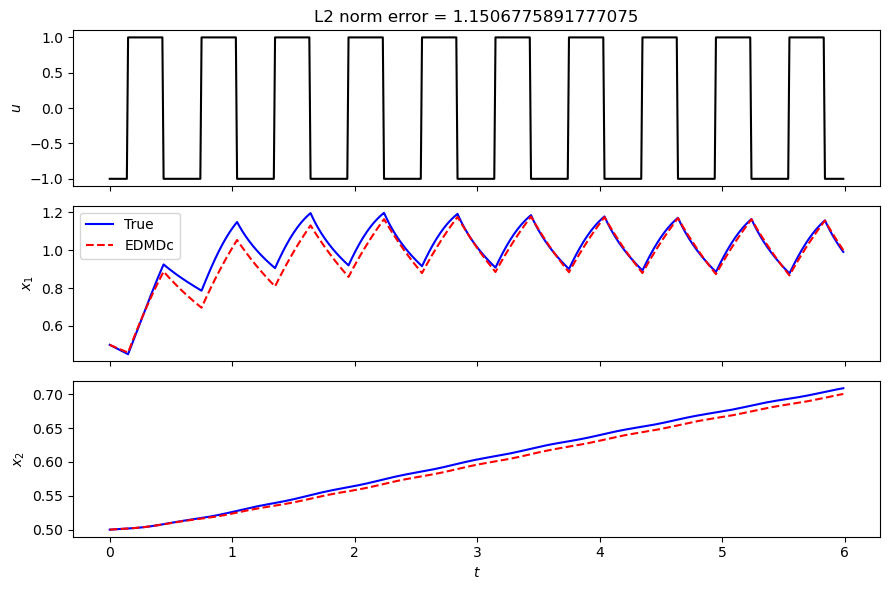

In [18]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop_poly[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop_poly[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop_poly.T)
axs[0].set_title(f"L2 norm error = {err}")

Text(0.5, 1.0, 'L2 norm error = 1.1506775891777075')

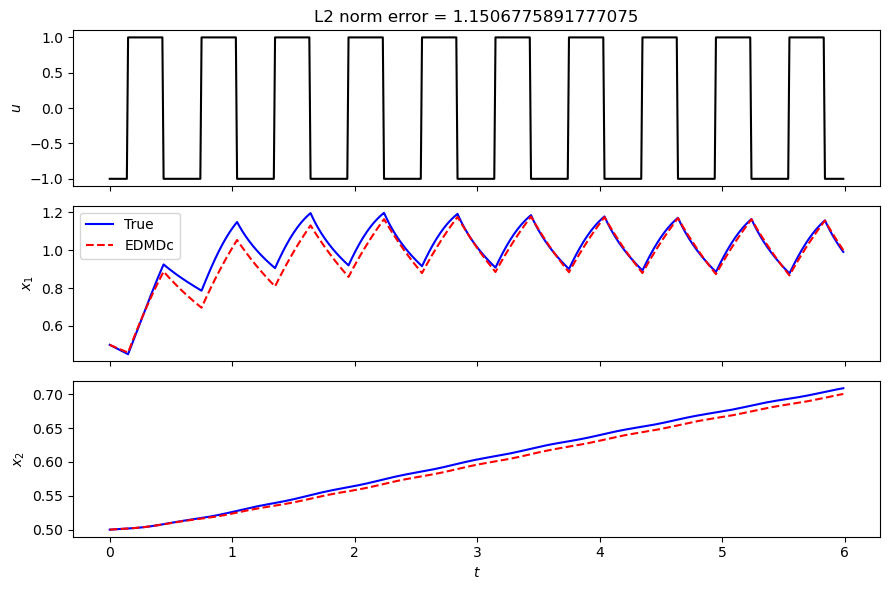

In [19]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop_poly[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop_poly[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop_poly.T)
axs[0].set_title(f"L2 norm error = {err}")

## Eigenfunction analysis

In [20]:
koop_eigenvals = np.log(np.linalg.eig(model.A)[0])/dT
print(f"koopman eigenvalues = {koop_eigenvals}")

koopman eigenvalues = [-1.14178636e+01+0.j         -2.63520738e+00+2.0167844j
 -2.63520738e+00-2.0167844j  -3.43455529e+00+0.j
 -2.15497955e+00+0.j         -1.33854257e+00+0.36723868j
 -1.33854257e+00-0.36723868j -7.43081115e-01+0.j
 -1.01624937e-02+0.03519349j -1.01624937e-02-0.03519349j
 -9.05711939e-02+0.05224527j -9.05711939e-02-0.05224527j]


In [21]:
koop_eigenvals_poly = np.log(np.linalg.eig(model_poly.A)[0])/dT
print(f"koopman eigenvalues of model using polynomial = {koop_eigenvals_poly}")

koopman eigenvalues of model using polynomial = [-4.18571915e+00+0.j         -2.29954147e+00+0.j
 -8.74702916e-01+0.j          1.24344979e-12+0.j
 -6.22767508e-02+0.01495897j -6.22767508e-02-0.01495897j]


In [22]:
efun_index, linearity_error = model.validity_check(t, Xtrue.T)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [ 3  0  2  1 10 11  4  9  8  7  6  5]
Corresponding linearity error:  [1.0411247996506061, 1.0646756962469108, 3.3564805766797257, 3.3564805766805015, 9.737858501959531, 9.737858501959538, 13.127765434871401, 16.285135395876896, 16.285135395876928, 95.55543857675926, 136.39639422255968, 136.396394222561]


In [23]:
efun_index_poly, linearity_error_poly = model_poly.validity_check(t, Xtrue.T)
print("Ranking of eigenfunctions by linearity error: ", efun_index_poly)
print("Corresponding linearity error: ", linearity_error_poly)

Ranking of eigenfunctions by linearity error:  [3 0 1 4 5 2]
Corresponding linearity error:  [4.5341923416977146e-10, 1.9577121343324952, 6.143755963479398, 12.571773933906973, 12.571773933906973, 20.288709182050745]


$E=\left\|\varphi(\mathbf{x}(t))-\mathrm{e}^{\lambda t} \varphi(\mathbf{x}(0))\right\|^2$

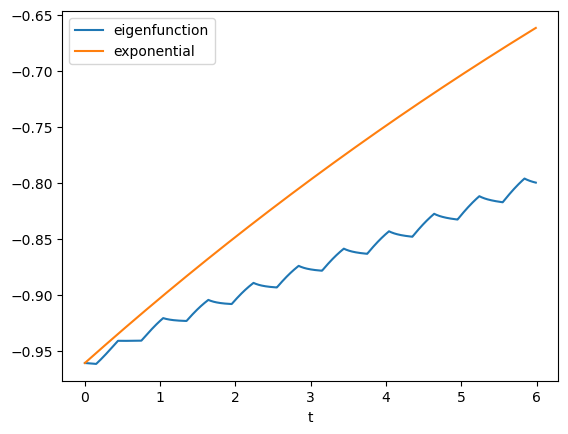

In [40]:
from math import exp
x = np.arange(600)*0.01
x_exp = np.exp(-6.22767508e-02*x)*phi_poly_test[5,0]
plt.plot(x,phi_poly_test[5],label='eigenfunction')
plt.plot(x,x_exp,label='exponential')
plt.legend()
plt.xlabel('t')
plt.show()

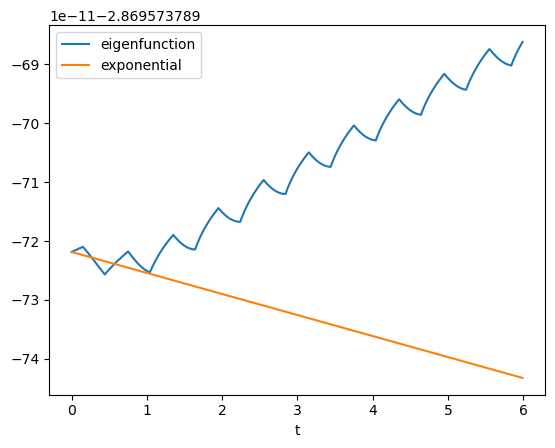

In [35]:
x = np.arange(600)*0.01
x_exp = np.exp(1.24344979e-12*x)*phi_poly_test[3,0]
plt.plot(x,phi_poly_test[3],label='eigenfunction')
plt.plot(x,x_exp,label='exponential')
plt.legend()
plt.xlabel('t')
plt.show()

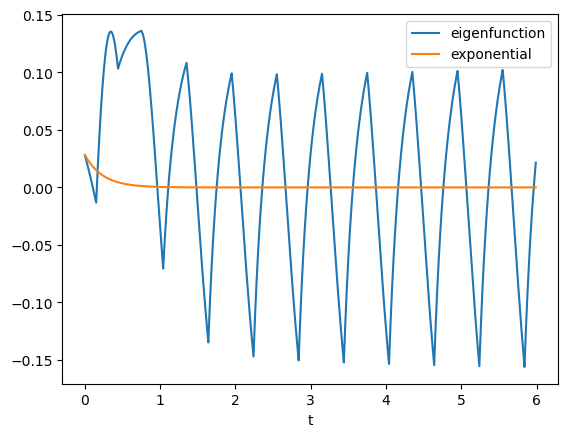

In [36]:
x = np.arange(600)*0.01
x_exp = np.exp(-4.18571915e+00*x)*phi_poly_test[0,0]
plt.plot(x,phi_poly_test[0],label='eigenfunction')
plt.plot(x,x_exp,label='exponential')
plt.legend()
plt.xlabel('t')
plt.show()

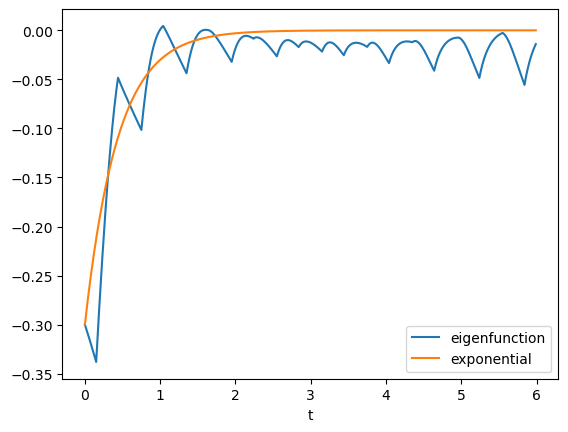

In [37]:
x = np.arange(600)*0.01
x_exp = np.exp(-2.29954147e+00*x)*phi_poly_test[1,0]
plt.plot(x,phi_poly_test[1],label='eigenfunction')
plt.plot(x,x_exp,label='exponential')
plt.legend()
plt.xlabel('t')
plt.show()

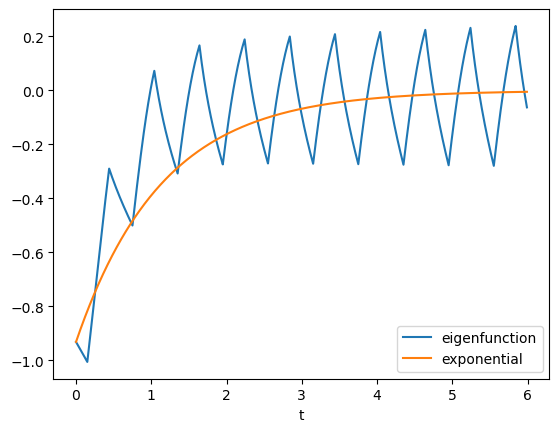

In [38]:
x = np.arange(600)*0.01
x_exp = np.exp(-8.74702916e-01*x)*phi_poly_test[2,0]
plt.plot(x,phi_poly_test[2],label='eigenfunction')
plt.plot(x,x_exp,label='exponential')
plt.legend()
plt.xlabel('t')
plt.show()

[legend.py:1323 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[legend.py:1323 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


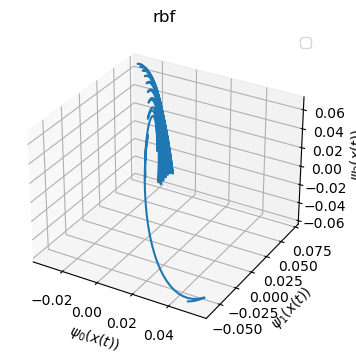

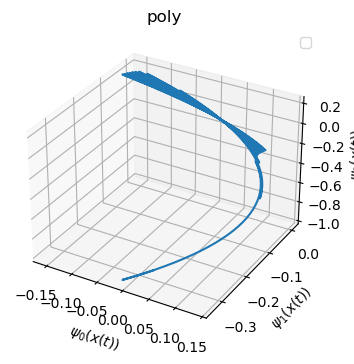

In [25]:
from mpl_toolkits.mplot3d import Axes3D

phi_edmd_test = model.psi(Xtrue)
phi_poly_test = model_poly.psi(Xtrue)

title_list = ['rbf','poly']
phi_list = [phi_edmd_test,phi_poly_test]

for i in range(2):
    phi = phi_list[i]
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(np.real(phi)[0,:],np.real(phi)[1,:],np.real(phi)[2,:])
    ax.set_xlabel(r'$\psi_0(x(t))$')
    ax.set_ylabel(r'$\psi_1(x(t))$')
    ax.set_zlabel(r'$\psi_2(x(t))$')
    
    plt.title(title_list[i])
    plt.legend(loc='best')

[legend.py:1323 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[legend.py:1323 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


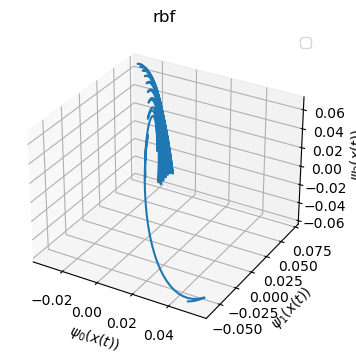

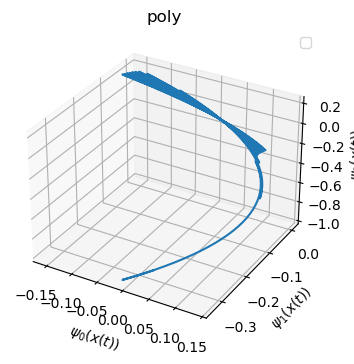

In [26]:
from mpl_toolkits.mplot3d import Axes3D

phi_edmd_test = model.psi(Xtrue)
phi_poly_test = model_poly.psi(Xtrue)

title_list = ['rbf','poly']
phi_list = [phi_edmd_test,phi_poly_test]

for i in range(2):
    phi = phi_list[i]
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(np.real(phi)[0,:],np.real(phi)[1,:],np.real(phi)[2,:])
    ax.set_xlabel(r'$\psi_0(x(t))$')
    ax.set_ylabel(r'$\psi_1(x(t))$')
    ax.set_zlabel(r'$\psi_2(x(t))$')
    
    plt.title(title_list[i])
    plt.legend(loc='best')

In [111]:
look_forward = 1
dlk_regressor = pk.regression.NNDMD(dt=dT, look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[64] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=64, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=10))

# train the vanilla NN model
model = pk.Koopman(regressor=dlk_regressor)
model.fit(X.T, Y.T, dt=dT)

INFO: GPU available: False, used: False
[rank_zero.py:48 -                _info() ] GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:48 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:48 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:48 -                _info() ] HPU available: False, using: 0 HPUs
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/pykoopman/regression/_nndmd.py:877: UserWarning: Warning: no validation data prepared
  warn("Warning: no validation data prepared")

Epoch 9: 100%|█| 3125/3125 [05:44<00:00,  9.07it/s, v_num=1, loss=nan.0, rec_los

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
[rank_zero.py:48 -                _info() ] `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 3125/3125 [05:44<00:00,  9.07it/s, v_num=1, loss=nan.0, rec_los


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=64,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [], 'input_size': 3,
                                        'output_size': 2},
                        config_encoder={'activations': 'swish',
                                        'hidden_sizes': [64, 64, 64],
                                        'input_size': 2, 'output_size': 3},
                        dt=0.01, lbfgs=True, normalize_std_factor=1.0,
                        trainer_kwargs={'max_epochs': 10}))

In [112]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x[np.newaxis,:], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

In [113]:
Xkoop

array([[0.5, 0.5],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

Text(0.5, 1.0, 'L2 norm error = nan')

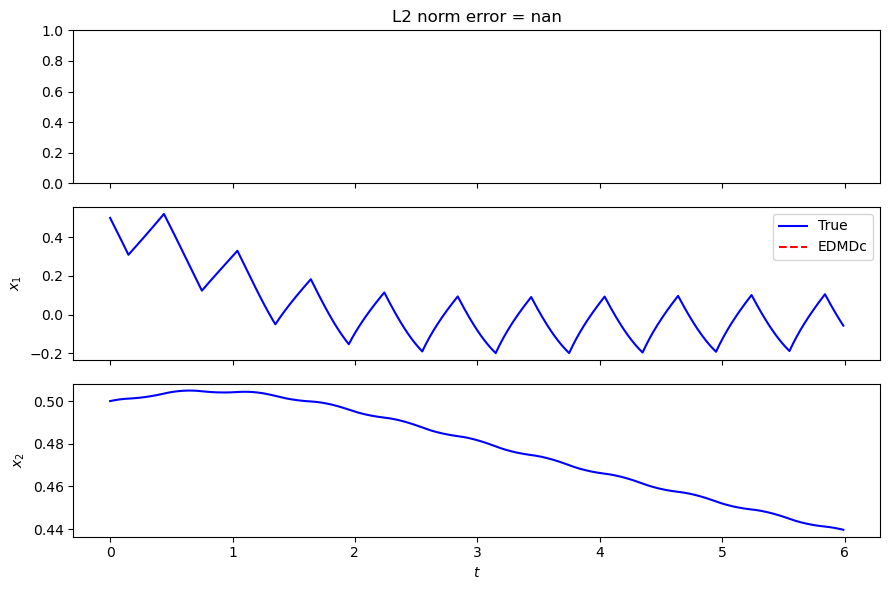

In [109]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop.T)
axs[0].set_title(f"L2 norm error = {err}")

## Optimal control

In [27]:
import control as ct
import control.optimal as opt

In [87]:
def fhn_update(t,x,u,params):
    r = -3* x[0]**3 + 4 *x[0]**2 - 3/2* x[0] 

    return np.array([
        r - x[1] + 0.378 + u[0],            
        (1/20)* (x[0] + 0  - 0.5* x[1])       
    ])

    #out=np.zeros(x.shape)
    #control=control.reshape(tsteps,N)
    #Coupling = 0
    #out[0]= R(x[0], 3 , 4, 3/2) - x[1] + 0.378 + u[0] + 0.21 * Coupling
    #out[1]= (1/20)* (x[0] + 0  - 0.5* x[1])
    #return out 
def fhn_output(t, x, u,params):
    return x  

In [88]:
fhn = ct.NonlinearIOSystem(
    fhn_update, fhn_output, states=2, name='fhn',
    inputs=('x1', 'x2'), outputs=('x1d', 'x2d'))

In [89]:
Q = np.eye(2)
R = 1
traj_cost = opt.quadratic_cost(fhn, Q, R)

In [90]:
x

array([0.5, 0.5])

In [91]:
timepts = np.linspace(0, Tf, 10, endpoint=True)
result = opt.solve_ocp(
    fhn, timepts, x, traj_cost)

Summary statistics:
* Cost function calls: 497
* System simulations: 1
* Final cost: 2.222536166610273


In [93]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.222536166610273
       x: [-1.881e-01 -1.073e-01 ...  3.980e-01  3.863e-01]
     nit: 12
     jac: [-2.092e-01 -2.391e-01 ...  8.844e-01  4.292e-01]
    nfev: 497
    njev: 12
 problem: <control.optimal.OptimalControlProblem object at 0x1869932d0>
    cost: 2.222536166610273
    time: [ 0.000e+00  1.111e+00  2.222e+00  3.333e+00  4.444e+00
            5.556e+00  6.667e+00  7.778e+00  8.889e+00  1.000e+01]
  inputs: [[-1.881e-01 -1.073e-01 ... -7.804e-04 -1.834e-04]
           [-2.924e-08 -7.923e-09 ...  1.447e-08  1.295e-08]]
  states: [[ 5.000e-01  7.763e-02 ... -1.875e-02 -1.000e-02]
           [ 5.000e-01  5.021e-01 ...  3.980e-01  3.863e-01]]

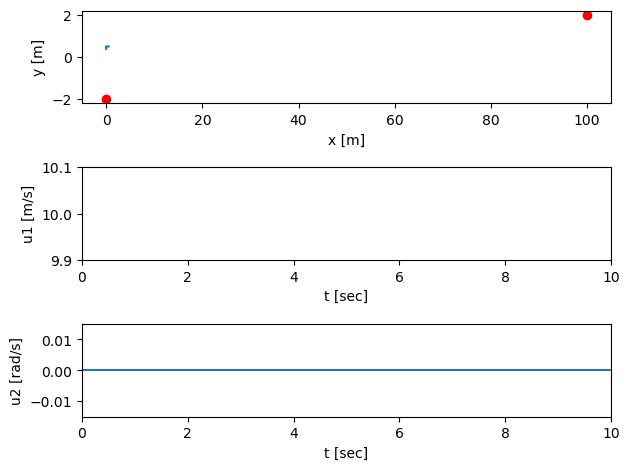

In [96]:
# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    fhn, timepts, result.inputs, x,
    t_eval=np.linspace(0, Tf, 100))
t, y, u = resp.time, resp.outputs, resp.inputs

plt.subplot(3, 1, 1)
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.subplot(3, 1, 2)
plt.plot(t, u[0])
plt.axis([0, 10, 9.9, 10.1])
plt.xlabel("t [sec]")
plt.ylabel("u1 [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[1])
plt.axis([0, 10, -0.015, 0.015])
plt.xlabel("t [sec]")
plt.ylabel("u2 [rad/s]")

plt.tight_layout()
plt.show()

LQR Koopman

In [160]:
obsv_poly.get_feature_names(["x1", "x2"])

['1',
 'x1',
 'x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3']

In [163]:
Q = np.zeros((model_poly.A.shape[0],model_poly.A.shape[0]))
Q[1,1] = 1
Q[2,2] = 1
R = 1
K, S, E = ct.lqr(model_poly.A,model_poly.B,Q,R)

In [165]:
K

array([[ 4.81683965e+13,  9.48476205e+07, -1.20652546e+09,
         2.13573137e+07, -3.17944357e+08,  2.27334071e+09,
        -3.95654799e+07,  1.20889835e+08,  7.74190437e+07,
         2.27415506e+08]])

In [122]:
model_poly.A.shape

(6, 6)

In [123]:
import scipy

A = model_poly.A
B = model_poly.B
Q = np.diag([1.0, 1.0, 0., 0.,0.,0.])
R = np.diag([1.0]) * 1e-2
P = scipy.linalg.solve_continuous_are(A, B, Q, R)
Klqr = np.linalg.inv(R).dot(B.T.dot(P))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinAlgError: Failed to find a finite solution.

## MPC

In [125]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = True
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 4000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [128]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint, add_slack=True)

NameError: name 'linearized_sys' is not defined